In [6]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# Sellers

Goal: find Sellers that repeatedly underperform vs others, and understand why.

## 2 - Exploration

### 2.1 - Plots

In [3]:
# Your code
from olist.seller import Seller
seller = Seller()
sellers = seller.get_training_data()
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,share_of_one_stars,share_of_five_stars,review_score,n_orders,quantity,quantity_per_order,sales
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,1.514329,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,0.333333,0.333333,3.00,3,3,1.000,218.70
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.155190,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,0.050000,0.725000,4.55,40,41,1.025,11703.07
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.000000,1.000000,5.00,1,1,1.000,158.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.000000,1.000000,5.00,1,1,1.000,79.99
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,1.000000,0.000000,1.00,1,1,1.000,167.99


In [4]:
sellers.describe()

,delay_to_carrier,wait_time,share_of_one_stars,share_of_five_stars,review_score,n_orders,quantity,quantity_per_order,sales
count,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000
mean,0.584619,12.160414,0.124570,0.592130,4.086880,33.617508,37.859933,1.157178,4566.515906
std,2.459618,7.103208,0.191870,0.279057,0.810166,107.133714,121.458613,0.439363,14185.211617
min,0.000000,1.214178,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,6.500000
25%,0.000000,8.289263,0.000000,0.478261,3.818424,2.000000,3.000000,1.000000,239.800000
50%,0.000000,11.120969,0.063856,0.600000,4.200000,7.000000,8.000000,1.000000,893.500000
75%,0.163171,14.240673,0.166667,0.750000,4.625000,23.000000,26.000000,1.142857,3586.022500
max,45.434039,189.863160,1.000000,1.000000,5.000000,1854.000000,2033.000000,15.000000,229472.630000


### 2.2 - Model out review score with OLS

Explain sellers' review_score is to **model out the impact of various features on `review_score` with a multivariate-OLS in statsmodels.** 

Create an OLS with only the numerical features and standardize them to compare the regression coefficients together.

In [1]:
def standardize(df, features):
    df_standardized = df.copy()
    for f in features:
        mu = df[f].mean()
        sigma = df[f].std()
        df_standardized[f] = df[f].map(lambda x: (x - mu) / sigma)
    return df_standardized

In [7]:
features = ['delay_to_carrier', 'wait_time', 'n_orders', 'quantity', 'quantity_per_order', 'sales']
sellers_standardized = standardize(sellers, features)
model = smf.ols(formula=f"review_score ~ {'+ '.join(features)}", data=sellers_standardized).fit()

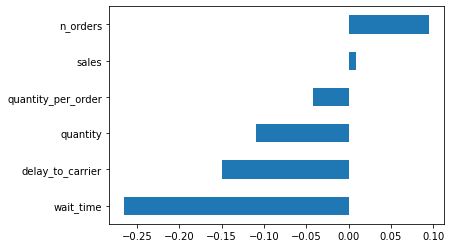

In [8]:
model.params[1:].sort_values().plot(kind='barh');

Investigate your model's performance (r-squared) and residuals

In [9]:
model.rsquared

0.20566169764305808

<AxesSubplot:xlabel='review_score', ylabel='Density'>

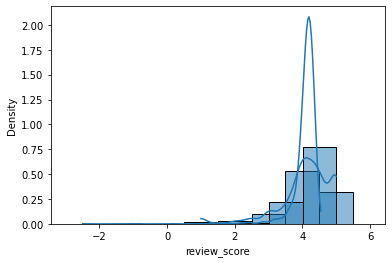

In [10]:
sns.histplot(sellers.review_score, kde=True, stat='density', discrete=True)
sns.histplot(model.predict(sellers_standardized[features]), kde=True, stat='density', discrete=True)

<AxesSubplot:ylabel='Density'>

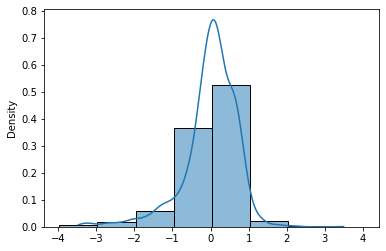

In [11]:
sns.histplot(model.resid, kde=True, stat='density', discrete=True)

### 2.3 - Analysing seller_state

- Create a new OLS model regressing `review_score` on `seller_states`
- Analyse significant features using `return_significative_coef(model)`
- What are the best states in terms of `review_score`? 

     
seller_state is a categorical feature. Use `C(a_cat_feature)` in the formula to indicate categorical variables. It will create one boolean variable `is_cat_feature_xx` **per unique category** 


In [15]:
formula = 'review_score ~ C(seller_state)'
model2 = smf.ols(formula=formula, data=sellers).fit()

# top 5 coef with p-value < 0.05
from olist.utils import return_significative_coef
return_significative_coef(model2).tail()

,variable,p_value,coef
12,C(seller_state)[T.PE],0.037755,1.775720
1,C(seller_state)[T.BA],0.034516,1.761179
15,C(seller_state)[T.RJ],0.031114,1.753333
21,C(seller_state)[T.SP],0.033357,1.725870
3,C(seller_state)[T.DF],0.039329,1.698606


☝️ Some states indeed have _signigicantly_ better reviews than others on average. Is it due to some lower `quantity_per_order`, lower `wait_time`, or `delay_to_carrier`? Or is it due to some other factors that we haven't collected data about?

To isolate the impact of the `seller_state` from the rest, add other continuous features to OLS until seller_states is no longer statistically siginificant.

In [17]:
formula = 'review_score ~ sales + quantity + quantity_per_order + C(seller_state)'
model3 = smf.ols(formula=formula, data=sellers).fit()
return_significative_coef(model3).tail()

,variable,p_value,coef
1,C(seller_state)[T.BA],0.032642,1.777841
15,C(seller_state)[T.RJ],0.029623,1.766617
21,C(seller_state)[T.SP],0.031132,1.745787
3,C(seller_state)[T.DF],0.036941,1.717306
24,quantity_per_order,0.000682,-0.115303


In [18]:
formula = 'review_score ~ wait_time + C(seller_state)'
model3 = smf.ols(formula=formula, data=sellers).fit()
return_significative_coef(model3).tail()

,variable,p_value,coef
0,Intercept,3.736081e-10,4.655252
22,wait_time,7.762819e-128,-0.048534



☝️ After adding `wait_time` to our analysis, none of the 22 dummy variables `is_seller_state_xx` are statistically signigicant:

Given the small dataset (most states have very few sellers):
- Not possible to conclude that "some states are inherently better than other for reasons that would be independent of the `wait_time`" 
- In other words, it's not possible to reject the hypothesis_ that "seller_state has no impact on review_score, other than through `wait_time`"